In [1]:
import os
from pathlib import Path
from collections import defaultdict
from PIL import Image, UnidentifiedImageError
import wsq
import shutil, random, math
import tqdm
import cv2
from scipy.ndimage import maximum_filter


from tools.incits378 import Template, Minutia

In [2]:
def parse_fingerprint_name(stem):
    parts = stem.split('_')
    if len(parts) >= 3:
        nia, seq, fgp = parts[0], parts[1], parts[2]
        return nia, seq, fgp
    elif len(parts) == 2:
        nia, fgp = parts[0], parts[1]
        return nia, "0", fgp
    else:
        return stem, "0", "0"

def organize_and_rename(
    original_root, train_root, test_root, issues_root,
    min_samples=1
):
    orig_images = Path(original_root) / 'images'
    orig_templates = Path(original_root) / 'templates'
    train_images = Path(train_root) / 'images'
    train_templates = Path(train_root) / 'templates'
    test_images = Path(test_root) / 'images'
    issues_images = Path(issues_root) / 'images'

    train_images.mkdir(parents=True, exist_ok=True)
    train_templates.mkdir(parents=True, exist_ok=True)
    test_images.mkdir(parents=True, exist_ok=True)
    issues_images.mkdir(parents=True, exist_ok=True)

    finger_groups = defaultdict(list)
    for img_path in orig_images.glob('*.wsq'):
        # Try to open the image now, to catch errors early
        try:
            img = Image.open(img_path)
            img.close()
        except (UnidentifiedImageError, OSError) as e:
            print(f"⚠️  Problem with image {img_path.name}, moving to issues.")
            shutil.move(str(img_path), str(issues_images / img_path.name))
            continue

        nia, seq, fgp = parse_fingerprint_name(img_path.stem)
        tpl_path = orig_templates / f"{img_path.stem}.incits378"
        has_tpl = tpl_path.exists()
        finger_groups[(nia, fgp)].append((img_path, seq, has_tpl, tpl_path))

    finger_id = 0
    test_count = 0

    for (nia, fgp), entries in sorted(finger_groups.items()):
        samples_with_template = [e for e in entries if e[2]]
        samples_without_template = [e for e in entries if not e[2]]

        if len(samples_with_template) >= min_samples:
            for sample_idx, (img_path, seq, has_tpl, tpl_path) in enumerate(sorted(samples_with_template, key=lambda x: int(x[1]))):
                new_name = f"f{finger_id:05d}_{sample_idx}.png"
                out_img_path = train_images / new_name
                try:
                    img = Image.open(img_path)
                    img.save(out_img_path)
                except (UnidentifiedImageError, OSError) as e:
                    print(f"⚠️  Problem converting {img_path.name}, moving to issues.")
                    shutil.move(str(img_path), str(issues_images / img_path.name))
                    continue
                out_tpl_path = train_templates / f"f{finger_id:05d}_{sample_idx}.incits378"
                shutil.copy2(str(tpl_path), str(out_tpl_path))
            for sample_idx, (img_path, seq, has_tpl, tpl_path) in enumerate(sorted(samples_without_template, key=lambda x: int(x[1]))):
                test_name = f"f{finger_id:05d}_{sample_idx}.png"
                out_test_img_path = test_images / test_name
                try:
                    img = Image.open(img_path)
                    img.save(out_test_img_path)
                except (UnidentifiedImageError, OSError) as e:
                    print(f"⚠️  Problem converting {img_path.name}, moving to issues.")
                    shutil.move(str(img_path), str(issues_images / img_path.name))
                    continue
                test_count += 1
            finger_id += 1
        else:
            for sample_idx, (img_path, seq, has_tpl, tpl_path) in enumerate(sorted(entries, key=lambda x: int(x[1]))):
                test_name = f"f{finger_id:05d}_{sample_idx}.png"
                out_test_img_path = test_images / test_name
                try:
                    img = Image.open(img_path)
                    img.save(out_test_img_path)
                except (UnidentifiedImageError, OSError) as e:
                    print(f"⚠️  Problem converting {img_path.name}, moving to issues.")
                    shutil.move(str(img_path), str(issues_images / img_path.name))
                    continue
                test_count += 1
            finger_id += 1

    print(f"✅ Training set: {finger_id} unique fingers written.")
    print(f"✅ Test set: {test_count} images written to {test_images}")
    print(f"⚠️  Check {issues_images} for problematic files.")

def count_high_sample_validation(
    train_root, val_root, sample_threshold=5
):
    from pathlib import Path
    import shutil

    train_images = Path(train_root) / 'images'
    train_templates = Path(train_root) / 'templates'
    train_maps = Path(train_root) / 'maps'
    val_images = Path(val_root) / 'images'
    val_templates = Path(val_root) / 'templates'
    val_maps = Path(val_root) / 'maps'

    val_images.mkdir(parents=True, exist_ok=True)
    val_templates.mkdir(parents=True, exist_ok=True)
    val_maps.mkdir(parents=True, exist_ok=True)

    moved_img_count = 0
    moved_tpl_count = 0

    # Go through all images in train_images
    for img_file in train_images.glob('f*.png'):
        stem = img_file.stem  # e.g., f00003_6
        if '_' not in stem:
            continue
        finger_id, sample_num_str = stem.split('_')
        try:
            sample_num = int(sample_num_str)
        except ValueError:
            continue
        if sample_num >= sample_threshold:
            # Uncomment below to actually move files!
            
            shutil.move(str(img_file), str(val_images / img_file.name))
            moved_img_count += 1

            tpl_file = train_templates / (finger_id + f'_{sample_num}.incits378')
            if tpl_file.exists():
                shutil.move(str(tpl_file), str(val_templates / tpl_file.name))
                moved_tpl_count += 1

            map_file = train_maps / (finger_id + f'_{sample_num}.npy')
            if map_file.exists():
                shutil.move(str(map_file), str(val_maps / map_file.name))
                moved_tpl_count += 1

    print(f"Moved {moved_img_count} images and {moved_tpl_count} templates to {val_root}/images and /templates.")



In [3]:
org = False

if org:
    organize_and_rename(
        original_root='dataset/original',
        train_root='dataset/training',
        test_root='dataset/test',
        issues_root='dataset/issues',
        min_samples=4
    )

In [4]:
mov = False

if mov:
    count_high_sample_validation(
        train_root='dataset/training',
        val_root='dataset/validation',
        #percent=0.2,  # 20%
        #seed=42       # for reproducibility
    )

# Moving 1405 fingers (1405/7026) to validation set.
# ✅ Moved 7369 images and 7369 templates to dataset/validation/images and /templates.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def dphi(theta1, theta2):
    """Smallest signed difference between two angles (radians), result in [-pi, pi)."""
    diff = theta1 - theta2
    diff = (diff + np.pi) % (2 * np.pi) - np.pi
    return np.abs(diff)

def generate_minutiae_map_paper(minutiae, image_shape, n_channels=6, sigma_s=2.0, sigma_o=0.5):
    h, w = image_shape
    H = np.zeros((h, w, n_channels), dtype=np.float32)
    # Precompute grid of pixel coordinates
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    for m in minutiae:
        x0, y0, theta0 = m.x, m.y, m.orientation
        # For all pixels (vectorized spatial Gaussian)
        spatial = np.exp(-((xx - x0)**2 + (yy - y0)**2) / (2 * sigma_s**2))
        for k in range(n_channels):
            phi_k = 2 * np.pi * k / n_channels
            orientation = np.exp(-dphi(theta0, phi_k)**2 / (2 * sigma_o**2))
            H[..., k] += spatial * orientation  # broadcast
    return H

def generate_minutiae_map(minutiae, image_shape, base_size=448, map_size=192, sigma_s=1.0, sigma_o=0.5):
    """
    Generate a minutiae heatmap from a list of Minutia objects.

    Args:
        minutiae (list): list of Minutia objects with x, y, orientation (in radians)
        image_shape (tuple): (height, width) of the original image
        base_size (int): the image size that corresponds to map_size (default 448)
        map_size (int): desired map size for a 448x448 image (default 192)
        sigma_s (float): spatial sigma
        sigma_o (float): orientation sigma
    Returns:
        np.ndarray: shape (H_map, W_map, 6)
    """
    h_img, w_img = image_shape
    scale = map_size / base_size
    h_map = int(h_img * scale)
    w_map = int(w_img * scale)
    
    H = np.zeros((h_map, w_map, 6), dtype=np.float32)

    # Just check if minutiae is empty or not a list
    if not minutiae or len(minutiae) == 0:
        return H  # return empty map

    for m in minutiae:
        x, y, theta = m.x, m.y, m.orientation
        mx = int(x * scale)
        my = int(y * scale)

        for i in range(6):  # 6 orientations
            o_k = 2 * np.pi * i / 6
            d_theta = np.abs(theta - o_k)
            d_theta = min(d_theta, 2*np.pi - d_theta)

            # Gaussian weights
            o_weight = np.exp(-d_theta**2 / (2 * sigma_o**2))

            for dx in range(-3, 4):  # 7x7 patch
                for dy in range(-3, 4):
                    nx = mx + dx
                    ny = my + dy
                    if 0 <= nx < w_map and 0 <= ny < h_map:
                        d_space = dx**2 + dy**2
                        s_weight = np.exp(-d_space / (2 * sigma_s**2))
                        H[ny, nx, i] += s_weight * o_weight

    return H

def plot_minutiae_map(H):
    """
    Display a 6-channel minutiae map as a 3x2 grid.
    Args:
        H: np.ndarray of shape (H, W, 6)
    """
    fig, axes = plt.subplots(2, 3, figsize=(6, 8))
    for i in range(6):
        ax = axes[i%2, i//2]
        ax.imshow(H[..., i], cmap='hot')
        ax.set_title(f'Channel {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def extract_minutiae_from_map_bf(H, threshold=0.5, nms_dist=8):
    """
    Convert 6-channel minutiae map H to list of (x, y, theta), using local maxima and non-max suppression.
    Args:
        H: (H, W, 6) numpy array
        threshold: minimum value for candidate minutia
        nms_dist: non-max suppression radius (pixels)
    Returns:
        minutiae: list of (x, y, theta)
    """
    h, w, n_ori = H.shape
    candidates = []

    for k in range(n_ori):
        channel = H[..., k]
        # Local maxima in 5x5
        maxima = (channel == maximum_filter(channel, size=5))
        peaks = np.argwhere(maxima & (channel > threshold))
        for y, x in peaks:
            score = channel[y, x]
            theta = 2 * np.pi * k / n_ori
            candidates.append((x, y, theta, score))

    # Non-maximal suppression across all orientations
    if not candidates:
        return []
    # Sort by score descending
    candidates.sort(key=lambda tup: -tup[3])
    selected = []
    taken = np.zeros((h, w), dtype=bool)
    for x, y, theta, score in candidates:
        if taken[y, x]:
            continue
        # Mark neighborhood as taken
        y0 = max(0, y - nms_dist)
        y1 = min(h, y + nms_dist + 1)
        x0 = max(0, x - nms_dist)
        x1 = min(w, x + nms_dist + 1)
        taken[y0:y1, x0:x1] = True
        selected.append((x, y, theta))
    return selected

def extract_minutiae_from_map(H, threshold=0.5, nms_dist=8):
    """
    Convert 6-channel minutiae map H to list of (x, y, theta), using local maxima and non-max suppression,
    with sub-channel (quadratic) orientation refinement.
    Assumes orientation bins are in [0, 2pi).
    Args:
        H: (H, W, 6) numpy array, channels represent evenly spaced orientations in [0, 2pi)
        threshold: minimum value for candidate minutia
        nms_dist: non-max suppression radius (pixels)
    Returns:
        minutiae: list of (x, y, theta)
    """
    h, w, n_ori = H.shape
    candidates = []

    bin_width = 2 * np.pi / n_ori  # now 2pi for 6 channels

    for k in range(n_ori):
        channel = H[..., k]
        maxima = (channel == maximum_filter(channel, size=5))
        peaks = np.argwhere(maxima & (channel > threshold))
        for y, x in peaks:
            y_m1 = H[y, x, (k - 1) % n_ori]
            y_0  = H[y, x, k]
            y_p1 = H[y, x, (k + 1) % n_ori]
            denom = y_m1 - 2 * y_0 + y_p1
            if denom == 0:
                delta = 0
            else:
                delta = 0.5 * (y_m1 - y_p1) / denom

            theta = ((k + delta) * bin_width) % (2 * np.pi)
            score = y_0
            candidates.append((x, y, theta, score))

    # Non-maximal suppression across all orientations
    if not candidates:
        return []
    candidates.sort(key=lambda tup: -tup[3])
    selected = []
    taken = np.zeros((h, w), dtype=bool)
    for x, y, theta, score in candidates:
        if taken[y, x]:
            continue
        y0 = max(0, y - nms_dist)
        y1 = min(h, y + nms_dist + 1)
        x0 = max(0, x - nms_dist)
        x1 = min(w, x + nms_dist + 1)
        taken[y0:y1, x0:x1] = True
        selected.append((x, y, theta))
    return selected

def draw_minutiae_on_image(img, minutiae, map_shape, img_shape, color=(0,0,255)):
    """
    Draws circles and orientation lines for each minutia.
    Args:
        img: np.ndarray, original image (grayscale or RGB)
        minutiae: list of (x, y, theta) in map coordinates
        map_shape: (h_map, w_map)
        img_shape: (h_img, w_img)
    """
    h_map, w_map = map_shape
    h_img, w_img = img_shape
    scale_x = w_img / w_map
    scale_y = h_img / h_map

    # Ensure BGR for cv2
    if len(img.shape) == 2:
        img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_vis = img.copy()

    for x, y, theta in minutiae:
        # Map from map coordinates to image coordinates
        ix = int(x * scale_x)
        iy = int(y * scale_y)

        cv2.circle(img_vis, (ix, iy), 4, color, 1)
        # Direction line: add pi/2 so 0 points up
        angle = theta + math.pi/2
        dx = int(15 * math.sin(angle))
        dy = int(15 * math.cos(angle))
        cv2.line(img_vis, (ix, iy), (ix + dx, iy + dy), color, 1)
    return img_vis

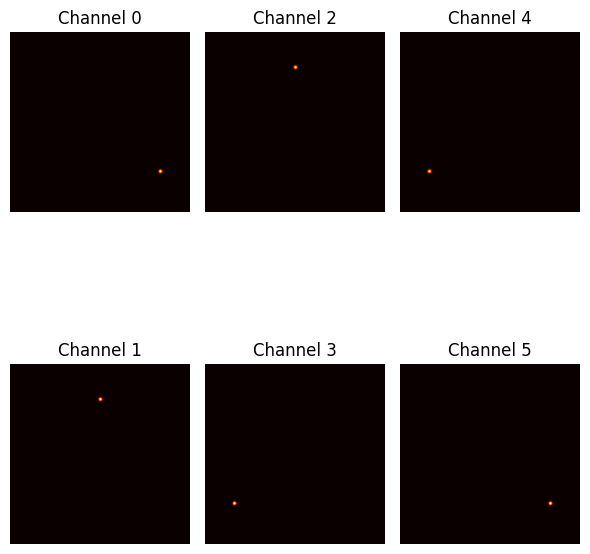

[(224, 88, 1.5707963267948966), (74, 346, -2.61950812590922), (374, 346, -0.522084527680573)]


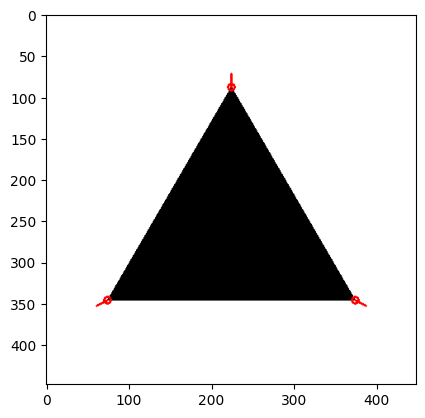

In [30]:
def generate_minutiae_map_paper_list(minutiae, image_shape, n_channels=6, sigma_s=2.0, sigma_o=0.5):
    h, w = image_shape
    H = np.zeros((h, w, n_channels), dtype=np.float32)
    # Precompute grid of pixel coordinates
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    for m in minutiae:
        x0, y0, theta0 = m
        # For all pixels (vectorized spatial Gaussian)
        spatial = np.exp(-((xx - x0)**2 + (yy - y0)**2) / (2 * sigma_s**2))
        for k in range(n_channels):
            phi_k = 2 * np.pi * k / n_channels
            orientation = np.exp(-dphi(theta0, phi_k)**2 / (2 * sigma_o**2))
            H[..., k] += spatial * orientation  # broadcast
    return H

def generate_minutiae_map_list(minutiae, image_shape, base_size=448, map_size=192, sigma_s=1.0, sigma_o=0.5):
    """
    Generate a minutiae heatmap from a list of Minutia objects.

    Args:
        minutiae (list): list of Minutia objects with x, y, orientation (in radians)
        image_shape (tuple): (height, width) of the original image
        base_size (int): the image size that corresponds to map_size (default 448)
        map_size (int): desired map size for a 448x448 image (default 192)
        sigma_s (float): spatial sigma
        sigma_o (float): orientation sigma
    Returns:
        np.ndarray: shape (H_map, W_map, 6)
    """
    h_img, w_img = image_shape
    scale = map_size / base_size
    h_map = int(h_img * scale)
    w_map = int(w_img * scale)
    
    H = np.zeros((h_map, w_map, 6), dtype=np.float32)

    # Just check if minutiae is empty or not a list
    if not minutiae or len(minutiae) == 0:
        return H  # return empty map

    for m in minutiae:
        x, y, theta = m
        mx = int(x * scale)
        my = int(y * scale)

        for i in range(6):  # 6 orientations
            o_k = 2 * np.pi * i / 6
            d_theta = np.abs(theta - o_k)
            d_theta = min(d_theta, 2*np.pi - d_theta)

            # Gaussian weights
            o_weight = np.exp(-d_theta**2 / (2 * sigma_o**2))

            for dx in range(-3, 4):  # 7x7 patch
                for dy in range(-3, 4):
                    nx = mx + dx
                    ny = my + dy
                    if 0 <= nx < w_map and 0 <= ny < h_map:
                        d_space = dx**2 + dy**2
                        s_weight = np.exp(-d_space / (2 * sigma_s**2))
                        H[ny, nx, i] += s_weight * o_weight

    return H

def draw_minutiae_on_image(img, minutiae, color=(255,0,0)):
    """
    Draws circles and orientation lines for each minutia.
    Args:
        img: np.ndarray, original image (grayscale or RGB)
        minutiae: list of (x, y, theta) in map coordinates
        map_shape: (h_map, w_map)
        img_shape: (h_img, w_img)
    """
    # Ensure BGR for cv2
    if len(img.shape) == 2:
        img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_vis = img.copy()

    for x, y, theta in minutiae:
        # Map from map coordinates to image coordinates
        ix = int(x * 1)
        iy = int(y * 1)

        cv2.circle(img_vis, (ix, iy), 4, color, 2)
        # Direction line: add pi/2 so 0 points up
        angle = theta + math.pi/2
        dx = int(16 * math.sin(angle))
        dy = int(16 * math.cos(angle))
        cv2.line(img_vis, (ix, iy), (ix + dx, iy + dy), color, 2)
    return img_vis

# Image size
img_size = 448
img = np.ones((img_size, img_size), dtype=np.uint8) * 255  # white background

# Triangle side length and height
side_length = 300
height = int(np.sqrt(3) / 2 * side_length)

# Center of image
center_x, center_y = img_size // 2, img_size // 2 + 36

# Coordinates of equilateral triangle (pointing up)
pt1 = (center_x, center_y - 2 * height // 3)  # top vertex
pt2 = (center_x - side_length // 2, center_y + height // 3)  # bottom left
pt3 = (center_x + side_length // 2, center_y + height // 3)  # bottom right

# Convert to numpy array for math
center = np.array([center_x, center_y])
pts = np.array([pt1, pt2, pt3])

# Compute outward unit vectors and angles
vectors = pts - center
angles = np.arctan2(vectors[:,1], vectors[:,0])  # angles in radians

# Minutiae list: (x, y, orientation)
# Compute outward directions using angle bisectors
minutiae = []
for i in range(3):
    curr = pts[i]
    prev = pts[(i - 1) % 3]
    next = pts[(i + 1) % 3]
    v1 = prev - curr
    v2 = next - curr
    bisector = -(v1 / np.linalg.norm(v1) + v2 / np.linalg.norm(v2))  # outward direction
    bisector[1] *= -1
    theta = np.arctan2(bisector[1], bisector[0])
    # theta += math.pi/12
    minutiae.append((int(curr[0]), int(curr[1]), float(theta)))

# Draw filled black triangle
pts = np.array([pt1, pt2, pt3], np.int32).reshape((-1, 1, 2))
out = cv2.fillPoly(img, [pts], color=0)
out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

mmap = generate_minutiae_map_list(minutiae, img.shape, sigma_s=1.2)
np.save('mmap.npy', mmap)

np.save('minutiae.npy', minutiae)
plot_minutiae_map(mmap)



# out = np.load('triangle.npy')


out = draw_minutiae_on_image(out, minutiae)

print(minutiae)
plt.imshow(out)

In [ ]:
# base_path = 'C:\\Users\\abis\\Documents\\dataset-fingerprints\\'
# image_path = base_path + 'images\\'
# templ_path = base_path + 'templates\\'
# maps_path  = base_path + 'maps\\'

# for fname in tqdm.tqdm(os.listdir(image_path)):
#     # print(fname)
#     tname = fname.split('.')[0] + '.incits378'
#     mname = fname.split('.')[0] + '.npy'

#     img = np.asarray(Image.open(image_path + fname))
#     if img is None:
#         continue

#     tpl = Template(templ_path + tname)
#     if len(tpl.minutiae) == 0:
#         continue

#     mmap = generate_minutiae_map(tpl.minutiae, img.shape, base_size=448, map_size=192, sigma_s=1.0, sigma_o=0.5)
#     np.save(maps_path + mname, mmap)
    

  1%|          | 263/36926 [00:22<52:06, 11.73it/s]  


KeyboardInterrupt: 

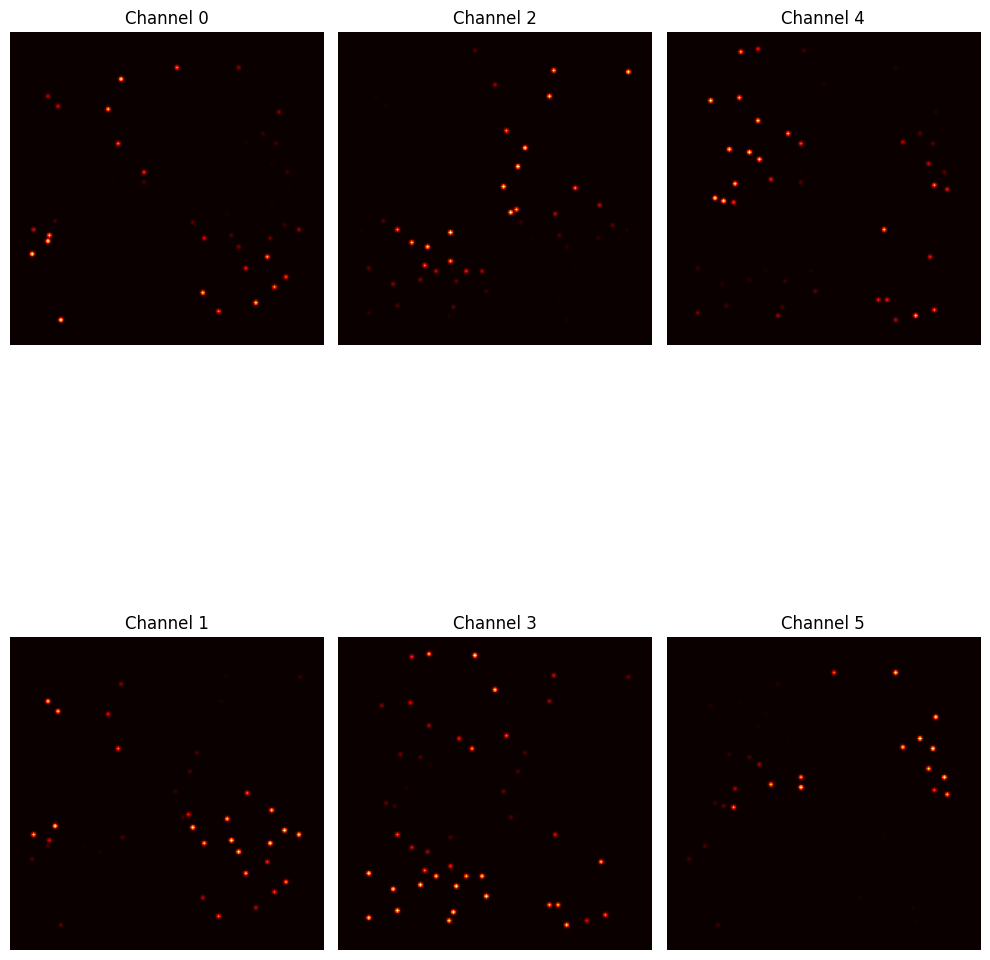

In [13]:
plot_minutiae_map(mmap)

In [ ]:
folder = 'dataset/validation/'
fname = 'f00003_0.png'
tname = fname.split('.')[0] + '.incits378'

img = np.asarray(Image.open(folder + 'images/' + fname))
tpl = Template(folder + 'templates/' + tname)
shape = np.asarray(img).shape

mmap = generate_minutiae_map(tpl.minutiae, shape, base_size=448, map_size=192, sigma_s=1.0, sigma_o=0.5)



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\abis\\Documents\\nicolas\\development\\deep-print\\dataset\\validation\\images\\f00003_0.png'

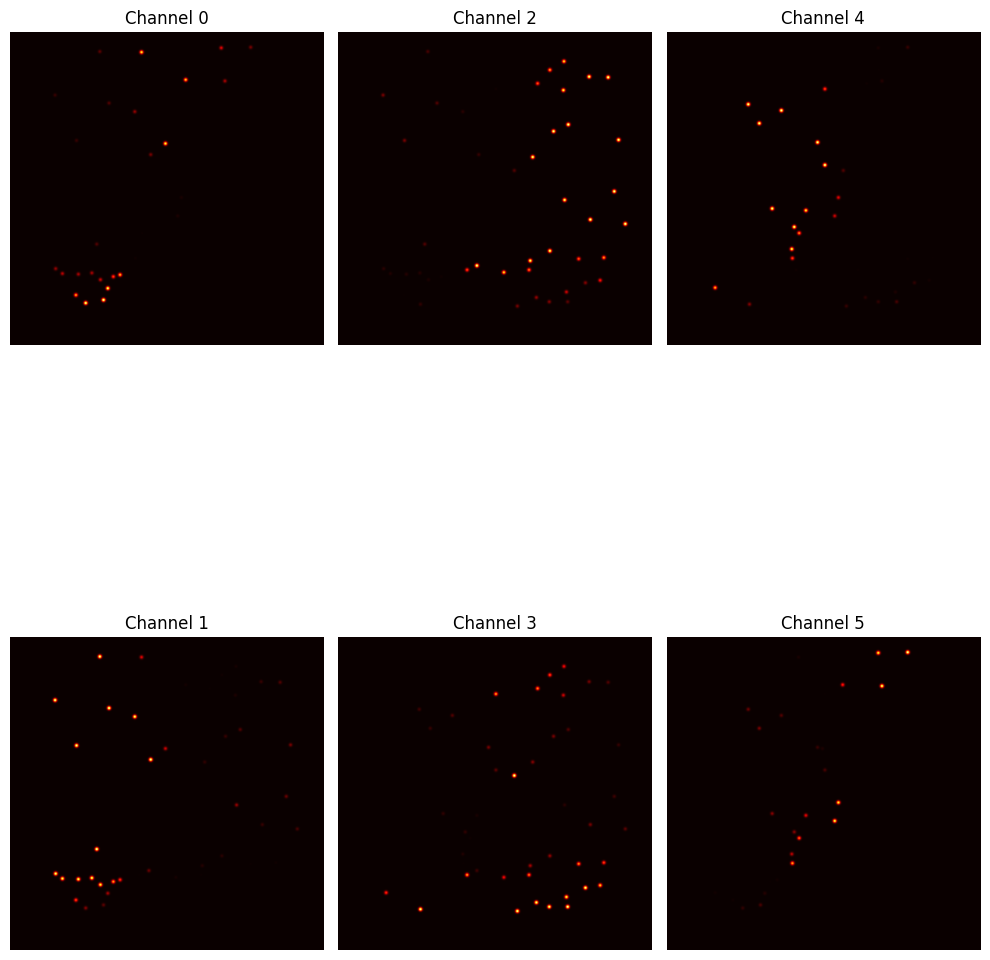

In [23]:
plot_minutiae_map(mmap2)

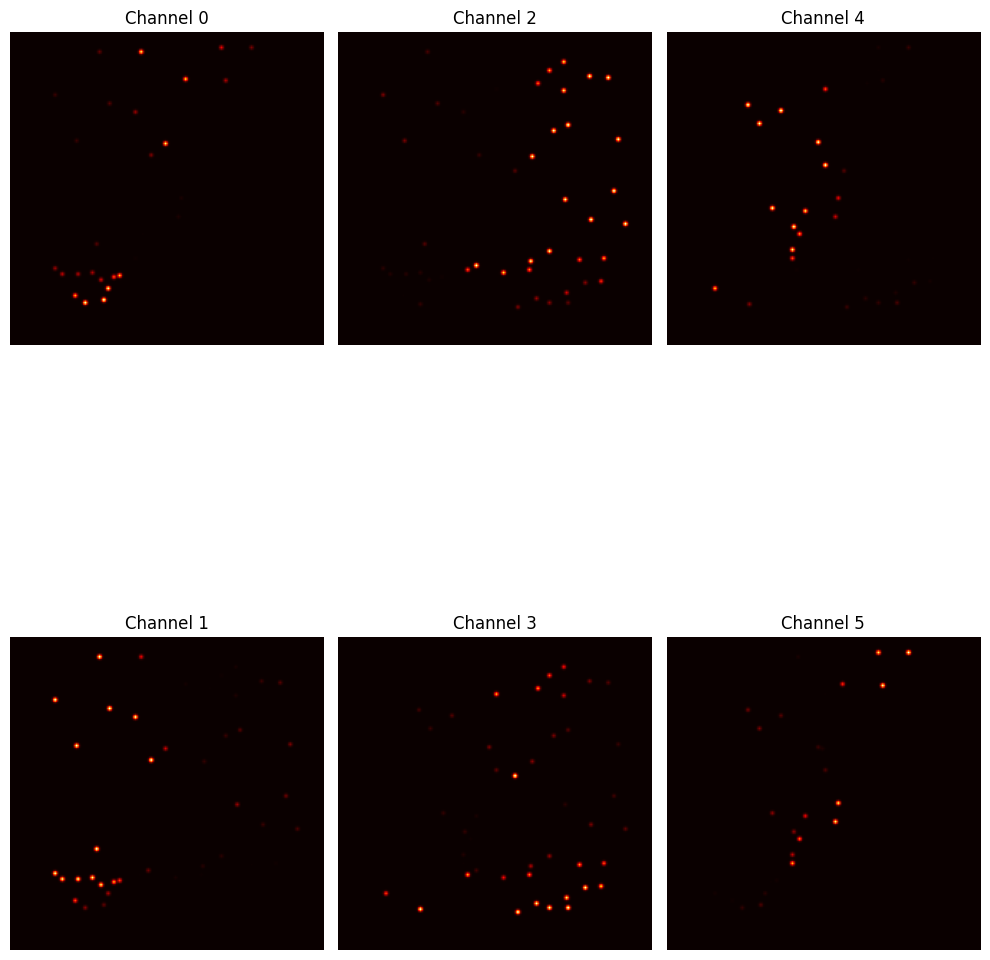

In [24]:
plot_minutiae_map(mmap)

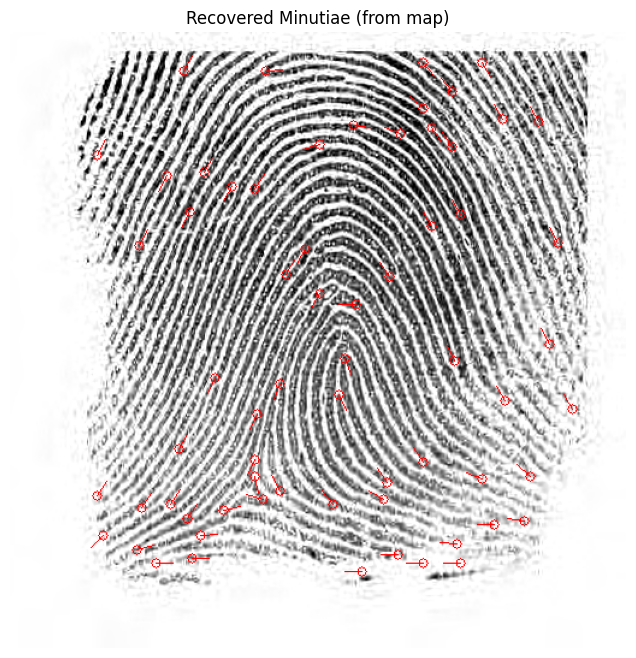

In [25]:
# 2. Draw on image
minutiae = extract_minutiae_from_map(mmap, 0.5, nms_dist=5)
result = draw_minutiae_on_image(img, minutiae, mmap.shape[:2], img.shape)

# 3. Show using matplotlib or cv2
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Recovered Minutiae (from map)")
plt.axis('off')
plt.show()

In [75]:
def batch_generate_maps(folder):
    templates_dir = Path(folder) / 'templates'
    images_dir = Path(folder) / 'images'
    maps_dir = Path(folder) / 'maps'
    maps_dir.mkdir(exist_ok=True)

    template_files = list(templates_dir.glob('*.incits378'))
    print(f"Processing {len(template_files)} templates...")

    for tpl_path in tqdm.tqdm(template_files):
        base = tpl_path.stem  # e.g., f00003_0
        img_path = images_dir / f"{base}.png"
        map_path = maps_dir / f"{base}.npy"

        # Skip if .npy already exists
        if map_path.exists():
            continue

        if not img_path.exists():
            print(f"Image not found for {base}, skipping.")
            continue

        # Load image to get shape
        img = Image.open(img_path)
        shape = np.asarray(img).shape

        # Load minutiae list using your Template class
        tpl = Template(str(tpl_path))
        minutiae = tpl.minutiae

        # Generate map
        H = generate_minutiae_map(minutiae, shape)

        # Save as .npy
        np.save(map_path, H)
        # print(f"Saved {map_path}")

In [76]:
batch_generate_maps('dataset/validation')

Processing 7369 templates...


100%|██████████| 7369/7369 [04:18<00:00, 28.56it/s] 


In [77]:
batch_generate_maps('dataset/training')

Processing 29500 templates...


100%|██████████| 29500/29500 [17:40<00:00, 27.80it/s]
